#### Advanced preprocessing
- stop-words removal
- URLs replaced with domain names
- characters with no information filtered
- 4 classes with no support merged

#### Basic transformation
- count vectorizer
- tf-idf normalization

#### LinearSVC
- Randomized Search for parameter tunning
- OvR approach using parameter multi_class='ovr'

In [1]:
import nltk
import numpy as np
import pandas as pd
import re
import sklearn
import urllib.request as req

from django.core.validators import URLValidator
from django.core.exceptions import ValidationError

from nltk import WordNetLemmatizer
from nltk import PorterStemmer
from nltk import word_tokenize
from nltk.corpus import wordnet

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import learning_curve

from scipy.stats import expon
from scipy.stats import randint as sp_randint

from urllib.parse import urlparse
from tldextract import extract

import warnings
warnings.filterwarnings('ignore')

# 1. Load data

In [2]:
df = pd.read_csv('../mbti_1.csv')

### Preprocessing

In [3]:
df['posts'] = df['posts'].replace(to_replace="\|\|\|", value=" ", regex=True)
df['posts'] = df['posts'].str[1:-1]

In [4]:
df['type'] = df['type'].replace(to_replace="ESTP", value="ES*")
df['type'] = df['type'].replace(to_replace="ESFP", value="ES*")
df['type'] = df['type'].replace(to_replace="ESFJ", value="ES*")
df['type'] = df['type'].replace(to_replace="ESTJ", value="ES*")

In [5]:
df.head()

,type,posts
0,INFJ,http://www.youtube.com/watch?v=qsXHcwe3krw htt...
1,ENTP,I'm finding the lack of me in these posts very...
2,INTP,Good one _____ https://www.youtube.com/watc...
3,INTJ,"Dear INTP, I enjoyed our conversation the ot..."
4,ENTJ,You're fired. That's another silly misconcepti...


In [6]:
# Replace URLs with domain names
for index, row in df.iterrows():
    urls = re.findall('(?P<url>https?://[^\s]+)', row['posts'])
    for u in urls:
        row['posts'] = row['posts'].replace(u, extract(u).domain)

In [7]:
# Remove non-alfa-num chars with exceptions (?!-)
df['posts'] = df['posts'].replace(r'[^0-9a-zA-Z?!-]+', ' ', regex=True)

In [8]:
# Reduce multiple dashes to one
df['posts'] = df['posts'].replace(r'\-+', '-', regex=True)

In [9]:
# Remove dashes from beginning and end of every string
df['posts'] = df['posts'].replace(r'(^-+)|(-+$)', '', regex=True)

# 2. Train - Test split

In [10]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [11]:
X_train = train['posts'].values
X_test = test['posts'].values
Y_train = train['type'].values
Y_test = test['type'].values

In [12]:
X_train.size

6940

# 3. Encoding labels

In [13]:
le = LabelEncoder()
le.fit(Y_train)

LabelEncoder()

In [14]:
le.classes_

array(['ENFJ', 'ENFP', 'ENTJ', 'ENTP', 'ES*', 'INFJ', 'INFP', 'INTJ',
       'INTP', 'ISFJ', 'ISFP', 'ISTJ', 'ISTP'], dtype=object)

In [15]:
y_train_enc = le.transform(Y_train)
y_train_enc

array([5, 1, 3, ..., 5, 6, 7])

# 4. Classification pipeline
### with feature extraction and tf-idf

In [16]:
def get_wordnet_pos(treebank_tag):
    """
    Maps treebank tags to wordnet.
    This step is needed when doing lemmatization
    in combination with pos tagging.
    :return: corresponding wordnet tag object
    """
    # Decision block for mapping treebank tags to wordnet.
    # Source: http://stackoverflow.com/a/15590384/5491423
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [17]:
class LemmaTokenizer(object):
    """
    Based on: http://scikit-learn.org/stable/modules/feature_extraction.html#customizing-the-vectorizer-classes
    """
    def __init__(self):
        self.wnl = WordNetLemmatizer()

    def __call__(self, doc):
        return [self.wnl.lemmatize(t, get_wordnet_pos(pt)) for t, pt in nltk.pos_tag(word_tokenize(doc))]


class StemTokenizer(object):
    """
    Based on: http://scikit-learn.org/stable/modules/feature_extraction.html#customizing-the-vectorizer-classes
    """
    def __init__(self):
        self.ps = PorterStemmer()

    def __call__(self, doc):
        return [self.ps.stem(t) for t in word_tokenize(doc)]

In [18]:
# SVC Pipeline
def create_svc_pipe(norm='l2', C=1.0, loss='hinge'):
            
    svc_classifier = Pipeline([
        ('vectorizer', CountVectorizer(lowercase=True, 
                                       tokenizer=LemmaTokenizer(),
                                       stop_words='english'
                                        )),
        ('tfidf', TfidfTransformer(norm=norm)),
        ('clf', LinearSVC(C=C, loss=loss, multi_class='ovr', class_weight='balanced', verbose=100, random_state=42))])
    return svc_classifier

# 5. Training

In [20]:
svc_params = { 'tfidf__norm': ['l1','l2'],
              'clf__C': sp_randint(1, 100),
              'clf__loss': ['hinge', 'squared_hinge']
             }
n_iter = 3
cv = KFold(n_splits=2, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(create_svc_pipe(), 
                                   verbose=50,
                                   param_distributions=svc_params,
                                   n_iter=n_iter, 
                                   cv=cv, n_jobs=-1, 
                                   scoring='f1_weighted')

random_search.fit(X_train, y_train_enc)

Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV] clf__C=74, clf__loss=squared_hinge, tfidf__norm=l2 ..............
[CV] clf__C=74, clf__loss=squared_hinge, tfidf__norm=l2 ..............
[CV] clf__C=49, clf__loss=hinge, tfidf__norm=l2 ......................
[CV] clf__C=49, clf__loss=hinge, tfidf__norm=l2 ......................
[LibLinear][CV]  clf__C=49, clf__loss=hinge, tfidf__norm=l2, score=0.6012088504921448, total=21.5min
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 31.6min
[CV] clf__C=22, clf__loss=hinge, tfidf__norm=l1 ......................
[LibLinear][CV]  clf__C=74, clf__loss=squared_hinge, tfidf__norm=l2, score=0.6043424194977526, total=21.6min
[CV] clf__C=22, clf__loss=hinge, tfidf__norm=l1 ......................
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed: 31.7min remaining: 63.3min
[LibLinear][CV]  clf__C=74, clf__loss=squared_hinge, tfidf__norm=l2, score=0.6223452925965501, total=21.7min
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:

/home/delusionx/anaconda3/envs/knowledge_discovery/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/delusionx/anaconda3/envs/knowledge_discovery/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][CV]  clf__C=22, clf__loss=hinge, tfidf__norm=l1, score=0.5893496329560317, total=10.8min
[LibLinear][CV]  clf__C=22, clf__loss=hinge, tfidf__norm=l1, score=0.6168070436885912, total=10.9min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 47.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 47.6min finished
[LibLinear]

/home/delusionx/anaconda3/envs/knowledge_discovery/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


RandomizedSearchCV(cv=KFold(n_splits=2, random_state=42, shuffle=True),
          error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
  ...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=100))]),
          fit_params=None, iid=True, n_iter=3, n_jobs=-1,
          param_distributions={'tfidf__norm': ['l1', 'l2'], 'clf__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fed4b4f00f0>, 'clf__loss': ['hinge', 'squared_hinge']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='f1_weighted', verbose=50)

In [21]:
# Prints results of parameter tuning
df_results_rs = pd.DataFrame(random_search.cv_results_)
df_results_rs

/home/delusionx/anaconda3/envs/knowledge_discovery/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/delusionx/anaconda3/envs/knowledge_discovery/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/delusionx/anaconda3/envs/knowledge_discovery/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_sco

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__C,param_clf__loss,param_tfidf__norm,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,644.752264,655.458025,0.613344,1.000000,74,squared_hinge,l2,"{'clf__C': 74, 'clf__loss': 'squared_hinge', '...",1,0.604342,1.0000,0.622345,1.000000,7.650914,4.802403,0.009001,0.000000
1,643.012023,653.044659,0.611277,1.000000,49,hinge,l2,"{'clf__C': 49, 'clf__loss': 'hinge', 'tfidf__n...",2,0.601209,1.0000,0.621345,1.000000,7.267106,0.959595,0.010068,0.000000
2,352.494777,300.130196,0.603078,0.946669,22,hinge,l1,"{'clf__C': 22, 'clf__loss': 'hinge', 'tfidf__n...",3,0.589350,0.9435,0.616807,0.949837,3.577255,1.858902,0.013729,0.003169


In [23]:
# Lemmatization
print(len(random_search.best_estimator_.named_steps["vectorizer"].get_feature_names()))

105116


In [22]:
random_search.best_estimator_

Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
  ...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=100))])

# 6. Testing

In [24]:
predictions = random_search.predict(X_test)

In [25]:
y_test_enc = le.transform(Y_test)

In [53]:
# Default (without cross-validation)
precision_recall_fscore_support(y_test_enc, predictions, average='weighted')

/home/delusionx/anaconda3/envs/knowledge_discovery/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.6847286480101508, 0.6876080691642651, 0.6852009479280805, None)

In [40]:
# Classes with low support merged to one (without cross-validation)
precision_recall_fscore_support(y_test_enc, predictions, average='weighted')

(0.6842320025186109, 0.6858789625360231, 0.6840061642535726, None)

In [21]:
# Stemming (without cross-validation)
precision_recall_fscore_support(y_test_enc, predictions, average='weighted')

/home/delusionx/anaconda3/envs/knowledge_discovery/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.6789809482625633, 0.6789625360230548, 0.671172078828815, None)

In [294]:
# Default class report (without cross-validation)
print(classification_report(y_test_enc, predictions, target_names=le.classes_))

             precision    recall  f1-score   support

       ENFJ       0.53      0.46      0.49        41
       ENFP       0.63      0.71      0.67       125
       ENTJ       0.53      0.52      0.53        44
       ENTP       0.63      0.66      0.64       135
       ESFJ       0.25      0.29      0.27         7
       ESFP       0.00      0.00      0.00         8
       ESTJ       0.57      0.57      0.57         7
       ESTP       0.64      0.47      0.54        15
       INFJ       0.70      0.65      0.67       288
       INFP       0.74      0.76      0.75       370
       INTJ       0.68      0.69      0.69       193
       INTP       0.75      0.78      0.76       293
       ISFJ       0.82      0.71      0.76        45
       ISFP       0.54      0.53      0.53        53
       ISTJ       0.67      0.55      0.60        44
       ISTP       0.64      0.69      0.66        67

avg / total       0.68      0.69      0.69      1735



/home/delusionx/anaconda3/envs/knowledge_discovery/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [41]:
# Class report when merged classes (without cross-validation)
print(classification_report(y_test_enc, predictions, target_names=le.classes_))

             precision    recall  f1-score   support

       ENFJ       0.53      0.46      0.49        41
       ENFP       0.64      0.71      0.67       125
       ENTJ       0.59      0.52      0.55        44
       ENTP       0.64      0.65      0.65       135
        ES*       0.40      0.32      0.36        37
       INFJ       0.70      0.65      0.68       288
       INFP       0.74      0.77      0.75       370
       INTJ       0.67      0.68      0.68       193
       INTP       0.74      0.78      0.76       293
       ISFJ       0.81      0.67      0.73        45
       ISFP       0.56      0.55      0.55        53
       ISTJ       0.66      0.52      0.58        44
       ISTP       0.63      0.67      0.65        67

avg / total       0.68      0.69      0.68      1735



In [26]:
# Class report when merged classes (with CV and param tuning)
print(classification_report(y_test_enc, predictions, target_names=le.classes_))

             precision    recall  f1-score   support

       ENFJ       0.50      0.34      0.41        41
       ENFP       0.64      0.68      0.66       125
       ENTJ       0.70      0.52      0.60        44
       ENTP       0.63      0.61      0.62       135
        ES*       0.61      0.30      0.40        37
       INFJ       0.60      0.64      0.62       288
       INFP       0.68      0.75      0.71       370
       INTJ       0.61      0.69      0.65       193
       INTP       0.69      0.74      0.71       293
       ISFJ       0.89      0.53      0.67        45
       ISFP       0.58      0.47      0.52        53
       ISTJ       0.67      0.36      0.47        44
       ISTP       0.64      0.55      0.59        67

avg / total       0.65      0.65      0.64      1735



In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.0)

In [81]:
def report_to_dataframe(report):
    report_data = []
    for i in range(2, 14):
        row_data = list(filter(None, report.split('\n')[i].split(' ')))
        print(row_data)
        df_row = {}
        df_row['trieda'] = row_data[0]
        df_row['presnosť'] = float(row_data[1])
        df_row['pokrytie'] = float(row_data[2])
        df_row['F1'] = float(row_data[3])
        df_row['podpora'] = int(row_data[4])
        
        report_data.append(df_row)
    dataframe = pd.DataFrame.from_dict(report_data)
    return dataframe

report = classification_report(y_test_enc, predictions, target_names=le.classes_)
df_rep = report_to_dataframe(report)

['ENFJ', '0.50', '0.34', '0.41', '41']
['ENFP', '0.64', '0.68', '0.66', '125']
['ENTJ', '0.70', '0.52', '0.60', '44']
['ENTP', '0.63', '0.61', '0.62', '135']
['ES*', '0.61', '0.30', '0.40', '37']
['INFJ', '0.60', '0.64', '0.62', '288']
['INFP', '0.68', '0.75', '0.71', '370']
['INTJ', '0.61', '0.69', '0.65', '193']
['INTP', '0.69', '0.74', '0.71', '293']
['ISFJ', '0.89', '0.53', '0.67', '45']
['ISFP', '0.58', '0.47', '0.52', '53']
['ISTJ', '0.67', '0.36', '0.47', '44']


In [82]:
df_support = df_rep[['trieda', 'podpora']]
df_rep.set_index('trieda', inplace=True)
df_metrics = df_rep[['presnosť','pokrytie', 'F1']]


In [83]:
df_support = df_support.sort_values('podpora', ascending=False).reset_index(drop=True)

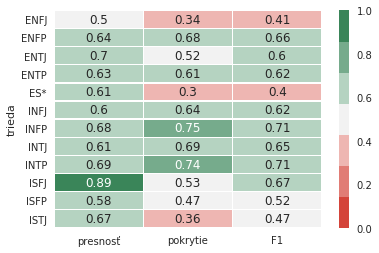

In [93]:
f, ax = plt.subplots()
color_palette = sns.diverging_palette(14, 141, sep=5, n=7)
heatmap = sns.heatmap(df_metrics, annot=True, vmin=0.0, vmax=1.0, linewidths=.4, ax=ax, cmap=color_palette)
heatfig = heatmap.get_figure()
heatfig.savefig("linearSVC_results.png", dpi=200)

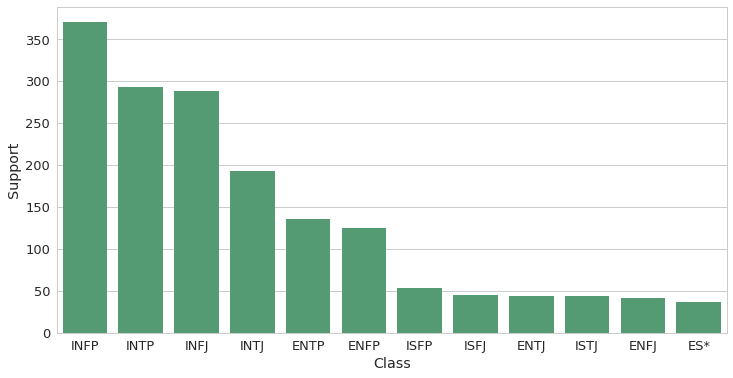

In [34]:
# Support in test sample
sns.set(font_scale=1.3)
sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(12, 6))
barplot = sns.barplot(data=df_support, x='trieda', y='podpora', color="mediumseagreen", saturation=.6)
barplot.set(xlabel='Class', ylabel='Support')
barfig = barplot.get_figure()
barfig.savefig("support.png")

In [19]:
# Learning curves (Precision / Recall)
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt


def plot_learning_curve(estimator, title, X, y, file=None, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5),
                        scoring='f1_weighted'):
    """
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
    """


    plt.figure()
    plt.title(title, fontsize=14)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Trénovacie vzorky", fontsize=14)
    plt.ylabel("Skóre (" + scoring + ")", fontsize=14)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, scoring=scoring, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Trén. skóre")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="CV skóre"),

    plt.legend(loc=3)
    plt.savefig(file, format='png', dpi=150)
    
    return plt

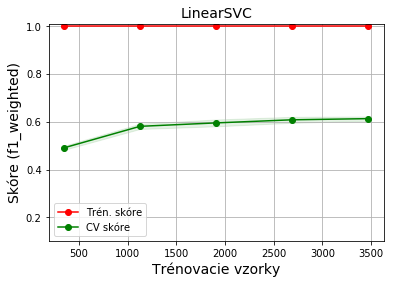

In [20]:
title = "LinearSVC"

C = random_search.best_params_.get('clf__C')
norm = random_search.best_params_.get('tfidf__norm')
loss = random_search.best_params_.get('clf__loss')

plt_p = plot_learning_curve(create_svc_pipe(C=C, norm=norm, loss=loss), title, 
                            X_train, y_train_enc, ylim=(0.1, 1.01), file='f1_linearSVC.png', 
                            cv=cv, n_jobs=-1, scoring='f1_weighted')